In [1]:
## import torch
import torchvision
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from torch.nn import functional as F
import time




In [18]:
#############################################################################################################
###
# PYTORCH DOCUMENTATION EXAMPLE
# TUTORIAL USED: #https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents/404_autoencoder.py
###
#### HYPER PARAMS
LR = 0.0005         # learning rate
N_TEST_IMG = 5

class Decoder_Base(nn.Module):
    def __init__(self):
        super(Decoder_Base, self).__init__()
        ###########################
        #What is this used for?
        #self.map = {}
        ###########################
        self.fc4 = nn.Linear(2, 50)
        self.sig = nn.Sigmoid()
        self.fc5 = nn.Linear(50, 784)

        
    def decode(self, z):
        out=self.fc4(z)
        out2=self.sig(out)
        out3=self.fc5(out2)
        out4=self.sig(out3)
        return out4
    
    def forward(self, x):
        encoded = x
        #decoded= x
        decoded = self.decode(encoded)
        return encoded, decoded
    
    
### INITALIZE MODEL PARAMS
model = Decoder_Base()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


def loss_function(recon_x, x):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    return(BCE)
def decode_loader(data, batch_size):
    perm = torch.randperm(data.size(0))
    idx = perm[:batch_size]
    batch=data[idx]
    return(batch)


## CUSTOM DATA LOADER
from torch.utils.data.dataset import Dataset
class rgenData(Dataset):
    def __init__(self, randEnc, x, transform=None):
        self.randEnc= randEnc
        self.x=x 
    def __len__(self):
        z=self.x.shape[0]
        return  z
    def __getitem__(self, idx):
        randEnc=self.randEnc[idx]
        x=self.x[idx]
        return randEnc, x

# Generate Train Data

## Pull in MNIST Data

In [8]:
#####################
## IMPORT MNIST DATA SET
batch_size_loader=100000
data_loader = torch.utils.data.DataLoader(
                            torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.ToTensor()),batch_size=batch_size_loader, shuffle=True)
examples = enumerate(data_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([60000, 1, 28, 28])

## Pull Training Images and Generate training tensors
###  Ω = randomlt generated vector in R2
###  Iteration= one pass through Decode
### RandEnc= a tensor containing the desired number of iterations of Ω 

In [9]:
def gen_data(num_img_type, img_return_cnt,example_data, max_i,Rdim):
    #num_img_type= scalar= equal to the number of image categories
    #img_return_cnt = array = index of array is the image type and value is sample size for image type
    #example_data = data loader data in form: batch_idx, (example_data, example_targets) 
    #max_i= data size
    #Rdim= vector dimension for rand generation
    found=False
    img_agg_cnt=np.zeros(num_img_type)
    img_return_cnt=np.array(img_return_cnt)
    i=0
    first=True
    while found==False and max_i>i:
        target=example_targets[i]
        if np.dot(np.subtract(img_agg_cnt, img_return_cnt),np.ones(num_img_type))==0:
            found=True
        else:
            if target<num_img_type:
                 if img_agg_cnt[target] < img_return_cnt[target]:
                        datum=example_data[i].view(-1,28*28)
                        img_agg_cnt[target]+=1
                        if first==True:
                            x_tensor=datum
                            randEnc_tensor=torch.rand(1, Rdim)
                            first=False 
                        else:
                            omega=torch.rand(1, Rdim)
                            x_tensor=torch.cat((x_tensor,datum),0)
                            randEnc_tensor=torch.cat((randEnc_tensor,omega),0)
        i+=1
    data = rgenData(randEnc_tensor, x_tensor)
    return(data)

## Run Model

In [14]:
def train_base(epoch, log_interval=10):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    lossvec=[]
    lossvec_cnt=[]
    cnt=0
    for i in range(1, epoch):
        for batch_idx, (randEnc, x) in enumerate(train_loader):
            cnt+=1
            encoded, decoded = model(randEnc)
            loss = loss_function(decoded, x)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            '''
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    i, batch_idx * len(x), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(x)))
            '''
        lossvec.append(train_loss / (len(train_loader.dataset)*i))
        lossvec_cnt.append(i)
        
    return (lossvec, lossvec_cnt)

In [25]:
EPOCH=1000000

## Experiment #1
### Baseline
#### One image type but different images

--- datagen secs %---
0.007878303527832031
--- train mins %---
5.916840140024821
10


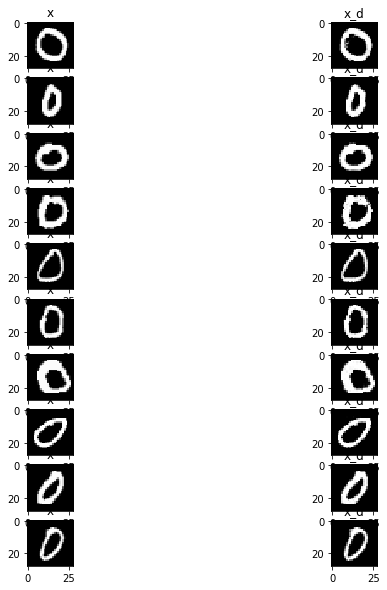

In [20]:
### Adjustable Params

#ADJUSTABLE
#SET THE NUMBER OF DIFFERENT TYPES OF IMAGES
num_img_type=1

#name the tensors for model


####################################################################
## NO ADJUSTMENT REQUIRED
img_return_cnt=np.zeros(num_img_type)
exp_tensor=[]
exp_tensor_d=[]
####################################################################


#ADJUSTABLE
#SET THE NUMBER OF DIFFERENT TYPES OF IMAGE
img_return_cnt[0]=10
#img_return_cnt[1]=15
max_i=60000
rdim=2



####################################################################
## NO ADJUSTMENT REQUIRED BELOW THIS POINT
start_time = time.time()
data=gen_data(num_img_type, img_return_cnt,example_data, max_i,rdim)
print('--- datagen secs %---')
print((time.time() - start_time))

instances=int(np.dot(img_return_cnt,np.ones(num_img_type)))

start_time = time.time()
batch_size=instances
train_loader=torch.utils.data.DataLoader(
    data, batch_size=batch_size, shuffle=False)
model = Decoder_Base()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

lossvec, lossvec_cnt=train_base(EPOCH) 
print('--- train mins %---')
print((time.time() - start_time)/60)

###################################################################
instances=int(np.dot(img_return_cnt,np.ones(num_img_type)))
print(instances)

###################################################################


rows=instances
cols=2
tot=int(instances)*cols
fig = plt.figure(figsize=(rows, rows))
plt.tight_layout() 
# plot with various axes scales


loc=0

case=0
while case<(rows):
    # linear
    loc+=1
    tensor=data[case][1].view(28,28)      
    tensor_d=model.decode(data[case][0])
    tensor_d=tensor_d.view(28,28)
    plt.subplot(rows, cols, loc)
    plt.imshow(tensor.detach().numpy(),cmap='gray')
    plt.title('x')

    loc+=1
    # log
    plt.subplot(rows, cols, loc)
    plt.imshow(tensor_d.detach().numpy(),cmap='gray')
    plt.title('x_d')


    if case==0:
        exp_tensor=data[case][1]
        exp_tensor_d=model.decode(data[case][0])
        exp_omega=data[case][0]
    else:
        exp_tensor=torch.cat((exp_tensor,data[case][1]),0)
        exp_tensor_d=torch.cat((exp_tensor_d,model.decode(data[case][0])),0)
        exp_omega=torch.cat((exp_omega, data[case][0]),0)
    case+=1
plt.show()

#############################################################
#####
####  REQUIRES UPDATING TENSOR NAME

exp1_tensor=exp_tensor
exp1_tensor_d=exp_tensor_d
exp1_omega=exp_omega
exp1_lossvec=lossvec
exp1_lossvec_cnt=lossvec_cnt

--- datagen secs %---
0.011588335037231445
--- train mins %---
7.732161660989125
20


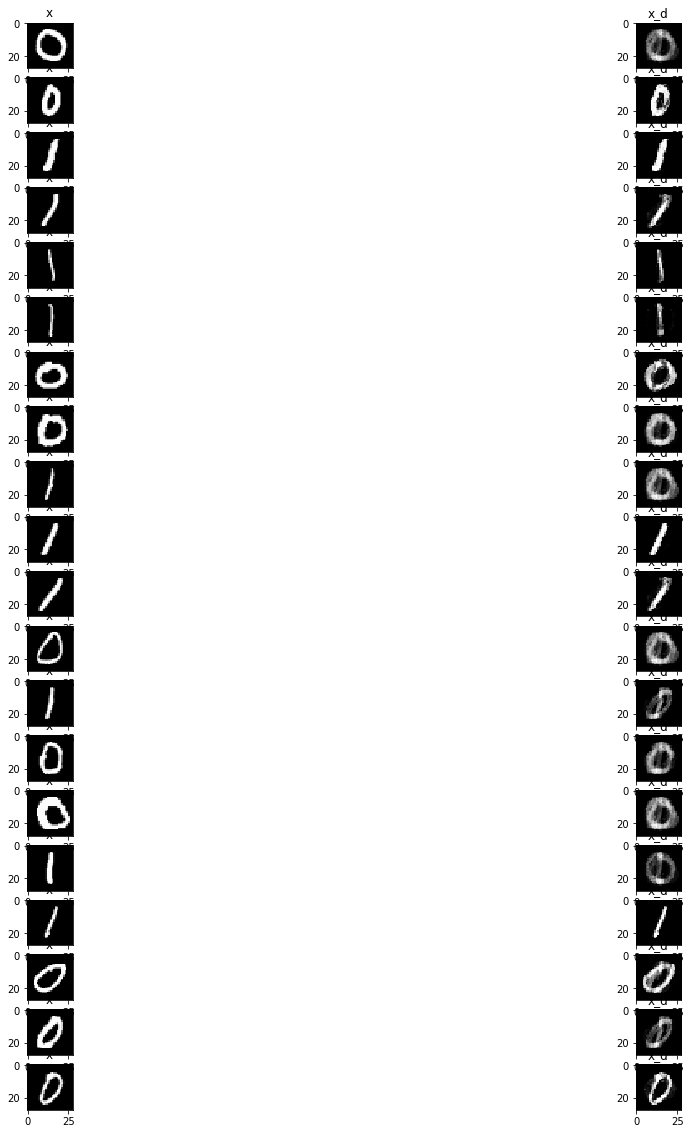

In [21]:
### Adjustable Params

#ADJUSTABLE
#SET THE NUMBER OF DIFFERENT TYPES OF IMAGES
num_img_type=2

#name the tensors for model


####################################################################
## NO ADJUSTMENT REQUIRED
img_return_cnt=np.zeros(num_img_type)
exp_tensor=[]
exp_tensor_d=[]
####################################################################


#ADJUSTABLE
#SET THE NUMBER OF DIFFERENT TYPES OF IMAGE
img_return_cnt[0]=10
img_return_cnt[1]=10
max_i=60000
rdim=2


####################################################################
## NO ADJUSTMENT REQUIRED BELOW THIS POINT
start_time = time.time()
data=gen_data(num_img_type, img_return_cnt,example_data, max_i,rdim)
print('--- datagen secs %---')
print((time.time() - start_time))

instances=int(np.dot(img_return_cnt,np.ones(num_img_type)))

start_time = time.time()
batch_size=instances
train_loader=torch.utils.data.DataLoader(
    data, batch_size=batch_size, shuffle=False)
model = Decoder_Base()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

lossvec, lossvec_cnt=train_base(EPOCH) 
print('--- train mins %---')
print((time.time() - start_time)/60)

###################################################################
instances=int(np.dot(img_return_cnt,np.ones(num_img_type)))
print(instances)

###################################################################


rows=instances
cols=2
tot=int(instances)*cols
fig = plt.figure(figsize=(rows, rows))
plt.tight_layout() 
# plot with various axes scales


loc=0

case=0
while case<(rows):
    # linear
    loc+=1
    tensor=data[case][1].view(28,28)      
    tensor_d=model.decode(data[case][0])
    tensor_d=tensor_d.view(28,28)
    plt.subplot(rows, cols, loc)
    plt.imshow(tensor.detach().numpy(),cmap='gray')
    plt.title('x')

    loc+=1
    # log
    plt.subplot(rows, cols, loc)
    plt.imshow(tensor_d.detach().numpy(),cmap='gray')
    plt.title('x_d')


    if case==0:
        exp_tensor=data[case][1]
        exp_tensor_d=model.decode(data[case][0])
        exp_omega=data[case][0]
    else:
        exp_tensor=torch.cat((exp_tensor,data[case][1]),0)
        exp_tensor_d=torch.cat((exp_tensor_d,model.decode(data[case][0])),0)
        exp_omega=torch.cat((exp_omega, data[case][0]),0)
    case+=1
plt.show()

#############################################################
#####
####  REQUIRES UPDATING TENSOR NAME

exp2_tensor=exp_tensor
exp2_tensor_d=exp_tensor_d
exp2_omega=exp_omega
exp2_lossvec=lossvec
exp2_lossvec_cnt=lossvec_cnt

--- datagen secs %---
0.006981372833251953
--- train mins %---
92.64052137931188
30


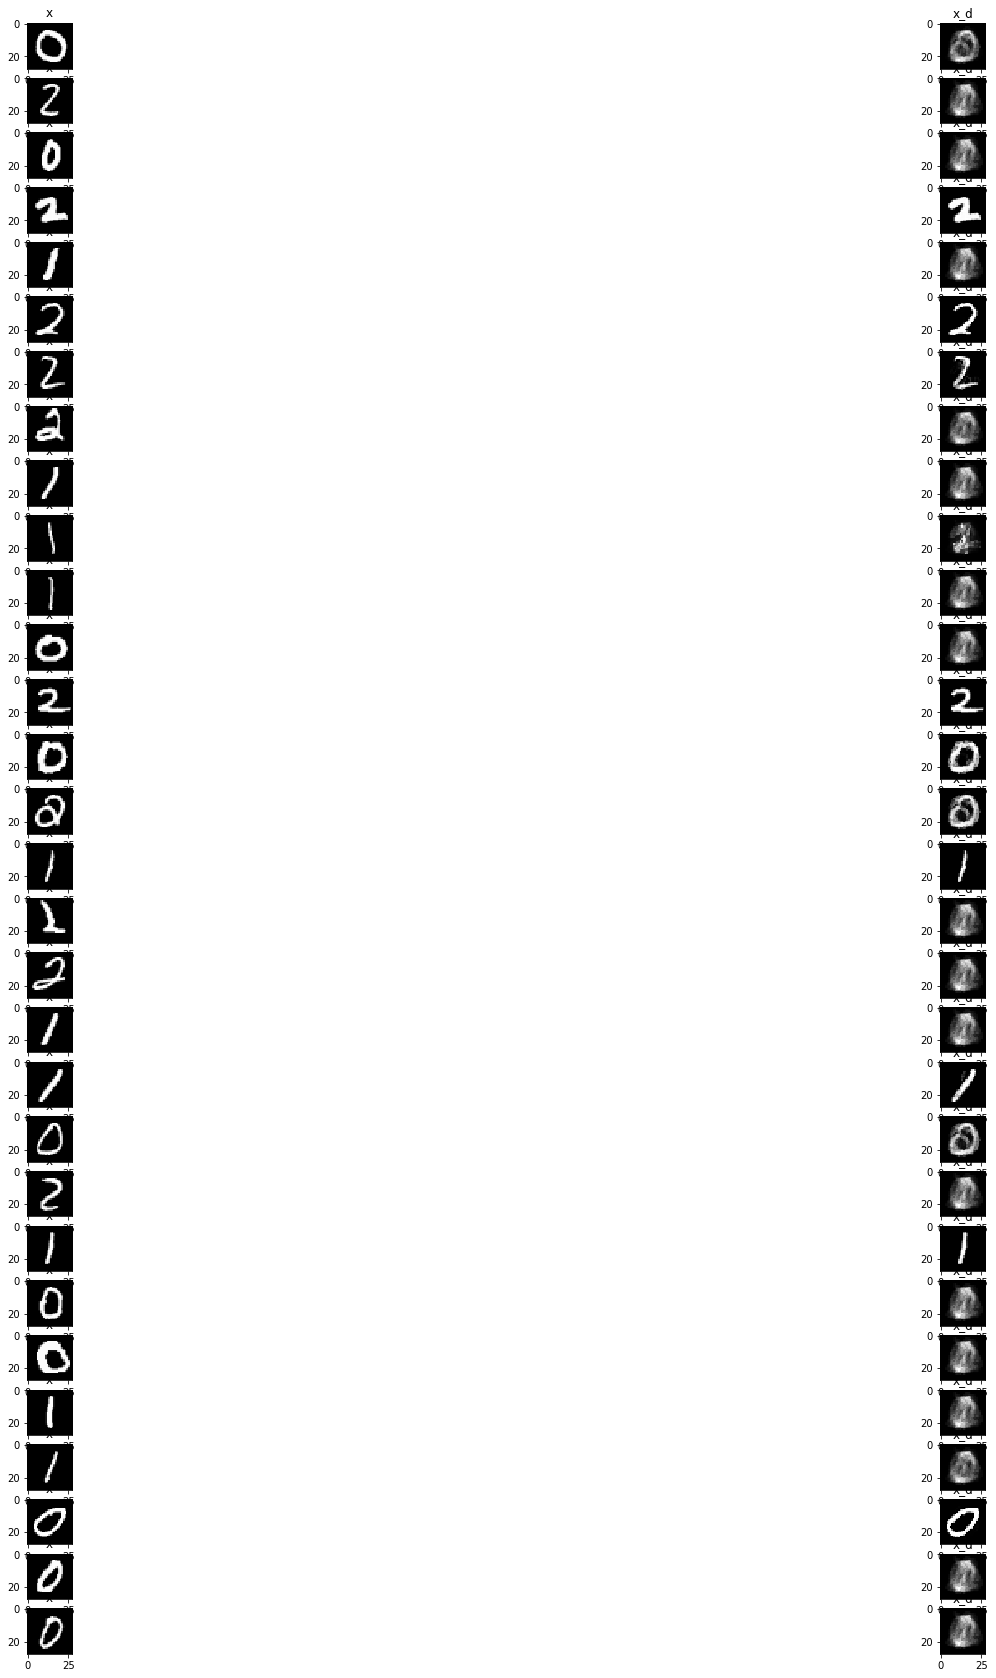

In [26]:
### Adjustable Params

#ADJUSTABLE
#SET THE NUMBER OF DIFFERENT TYPES OF IMAGES
num_img_type=3

#name the tensors for model


####################################################################
## NO ADJUSTMENT REQUIRED
img_return_cnt=np.zeros(num_img_type)
exp_tensor=[]
exp_tensor_d=[]
####################################################################


#ADJUSTABLE
#SET THE NUMBER OF DIFFERENT TYPES OF IMAGE
img_return_cnt[0]=10
img_return_cnt[1]=10
img_return_cnt[2]=10

max_i=60000
rdim=2




####################################################################
## NO ADJUSTMENT REQUIRED BELOW THIS POINT
start_time = time.time()
data=gen_data(num_img_type, img_return_cnt,example_data, max_i,rdim)
print('--- datagen secs %---')
print((time.time() - start_time))

instances=int(np.dot(img_return_cnt,np.ones(num_img_type)))

start_time = time.time()
batch_size=instances
train_loader=torch.utils.data.DataLoader(
    data, batch_size=batch_size, shuffle=False)
model = Decoder_Base()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

lossvec, lossvec_cnt=train_base(EPOCH) 
print('--- train mins %---')
print((time.time() - start_time)/60)

###################################################################
instances=int(np.dot(img_return_cnt,np.ones(num_img_type)))
print(instances)

###################################################################


rows=instances
cols=2
tot=int(instances)*cols
fig = plt.figure(figsize=(rows, rows))
plt.tight_layout() 
# plot with various axes scales


loc=0

case=0
while case<(rows):
    # linear
    loc+=1
    tensor=data[case][1].view(28,28)      
    tensor_d=model.decode(data[case][0])
    tensor_d=tensor_d.view(28,28)
    plt.subplot(rows, cols, loc)
    plt.imshow(tensor.detach().numpy(),cmap='gray')
    plt.title('x')

    loc+=1
    # log
    plt.subplot(rows, cols, loc)
    plt.imshow(tensor_d.detach().numpy(),cmap='gray')
    plt.title('x_d')


    if case==0:
        exp_tensor=data[case][1]
        exp_tensor_d=model.decode(data[case][0])
        exp_omega=data[case][0]
    else:
        exp_tensor=torch.cat((exp_tensor,data[case][1]),0)
        exp_tensor_d=torch.cat((exp_tensor_d,model.decode(data[case][0])),0)
        exp_omega=torch.cat((exp_omega, data[case][0]),0)
    case+=1
plt.show()

#############################################################
#####
####  REQUIRES UPDATING TENSOR NAME

exp1_tensor=exp_tensor
exp1_tensor_d=exp_tensor_d
exp1_omega=exp_omega
exp1_lossvec=lossvec
exp1_lossvec_cnt=lossvec_cnt

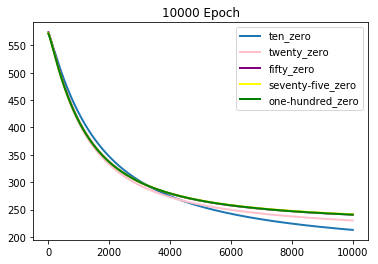

In [20]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Data
df=pd.DataFrame({'x': lossvec_cnt_100zero, 'ten_zero': np.asarray(lossvec_10zero), 'twenty_zero': np.asarray(lossvec_25zero), 
                 'fifty_zero': np.asarray(lossvec_50zero), 'seventy-five_zero': np.asarray(lossvec_75zero), 'one-hundred_zero': np.asarray(lossvec_100zero) })
 
# multiple line plot
plt.plot( 'x', 'ten_zero', data=df, marker='', markerfacecolor='blue', linewidth=2)
plt.plot( 'x', 'twenty_zero', data=df, marker='', color='pink', linewidth=2)
plt.plot( 'x', 'fifty_zero', data=df, marker='', color='purple', linewidth=2)
plt.plot( 'x', 'seventy-five_zero', data=df, marker='', color='yellow', linewidth=2)
plt.plot( 'x', 'one-hundred_zero', data=df, marker='', color='green', linewidth=2)
plt.title('10000 Epoch')
plt.legend()

